In [16]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/'
%mkdir './coursework'
%cd './coursework'
!git clone https://github.com/ShayD111/NLP_CW.git
%cd './NLP_CW'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks
mkdir: cannot create directory ‘./coursework’: File exists
/content/drive/MyDrive/Colab Notebooks/coursework
fatal: destination path 'NLP_CW' already exists and is not an empty directory.
/content/drive/MyDrive/Colab Notebooks/coursework/NLP_CW


In [17]:
!pip install simpletransformers
!pip install transformers
!pip install tensorboardx
!pip install wandb
!pip install numpy requests nlpaug

In [18]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import logging
import torch
import wandb
from torch import nn
from torch.utils.data import Dataset
from collections import Counter
from ast import literal_eval
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

from transformers import Trainer, TrainingArguments
from transformers import RobertaTokenizer, BertTokenizer, DebertaTokenizer, DebertaForSequenceClassification, DebertaPreTrainedModel
from transformers import RobertaPreTrainedModel, RobertaModel, BertForSequenceClassification, BertPreTrainedModel, BertPreTrainedModel, BertModel, DebertaModel

from google.colab import files
import io
import csv
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [19]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/'
%mkdir './coursework'
%cd './coursework'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks
mkdir: cannot create directory ‘./coursework’: File exists
/content/drive/MyDrive/Colab Notebooks/coursework


In [20]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [21]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## Fetch DontPatronizeMe! module:

In [22]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [23]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [24]:
from dont_patronize_me import DontPatronizeMe

In [25]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [69]:
#random seed
np.random.seed(0)
torch.manual_seed(0)

In [27]:
#load task 1
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

In [28]:
#load task 1
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [29]:
%cd '../'

/content/drive/MyDrive/Colab Notebooks


## ANALYSIS ON ORIGINAL DATA

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Original Label Frequencies')

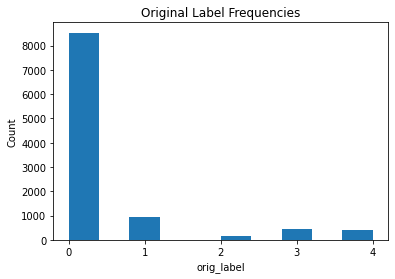

In [30]:
orig_train = dpm.train_task1_df
labels = orig_train["label"]
orig_labels = orig_train["orig_label"]

#plot distribution of original labels
plt.figure()
plt.hist(orig_labels)
plt.xlabel("orig_label")
plt.ylabel("Count")
plt.title("Original Label Frequencies")

In [31]:
def get_feature_frequencies(feature_df, feature_name = None, analyse_length=False):
  pos_vals = []
  neg_vals = []

  if analyse_length:
    lengths = np.array([len(txt) for txt in feature_df["text"]])
    lengths_pos, pos_counts = np.unique(lengths[feature_df["label"] == 1], return_counts=True)
    lengths_neg, neg_counts = np.unique(lengths[feature_df["label"] == 1], return_counts=True)
    
    return lengths_pos, lengths_neg, pos_counts, neg_counts

  else:
    for val in np.unique(feature_df[feature_name]):
      len_neg_val = len(feature_df.loc[(feature_df[feature_name] == val) & (feature_df["label"] == 0)])
      len_pos_val = len(feature_df.loc[(feature_df[feature_name] == val) & (feature_df["label"] == 1)])

      neg_vals.append(len_neg_val)
      pos_vals.append(len_pos_val)  

  return pos_vals, neg_vals

In [32]:
pos_keywords, neg_keywords = get_feature_frequencies(orig_train, feature_name="keyword")
pos_countries, neg_countries = get_feature_frequencies(orig_train, feature_name="country")

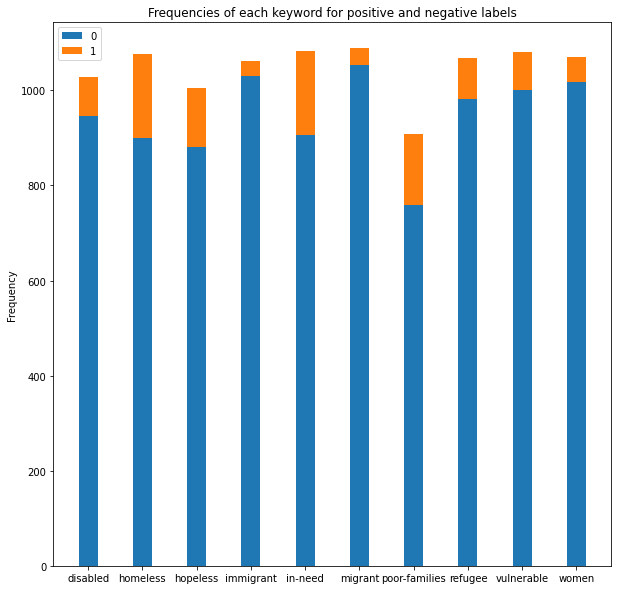

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(np.unique(orig_train["keyword"]), neg_keywords, width=0.35, label='0')
ax.bar(np.unique(orig_train["keyword"]), pos_keywords, width=0.35, bottom=neg_keywords,label='1')

ax.set_ylabel('Frequency')
ax.set_title('Frequencies of each keyword for positive and negative labels')
ax.legend()
plt.show()

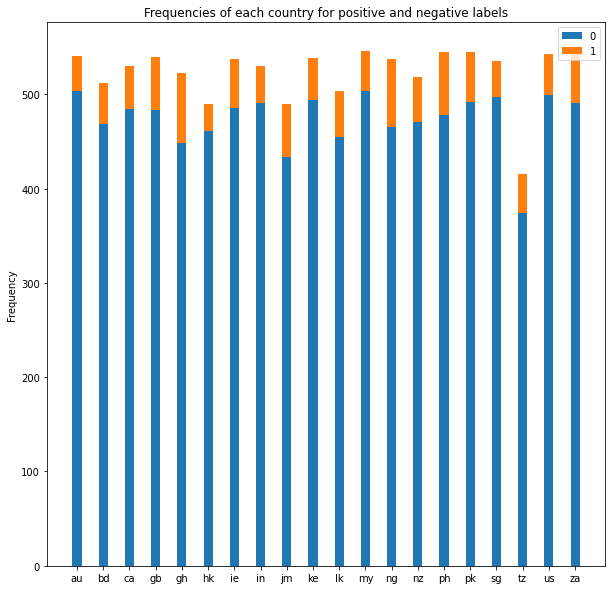

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(np.unique(orig_train["country"]), neg_countries, width=0.35, label='0')
ax.bar(np.unique(orig_train["country"]), pos_countries, width=0.35, bottom=neg_countries,label='1')

ax.set_ylabel('Frequency')
ax.set_title('Frequencies of each country for positive and negative labels')
ax.legend()
plt.show()

In [35]:
lengths_pos, lengths_neg, pos_counts, neg_counts = get_feature_frequencies(orig_train, analyse_length=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean positive text length = 288.45417925478347
Mean negative text length = 265.39573659772054


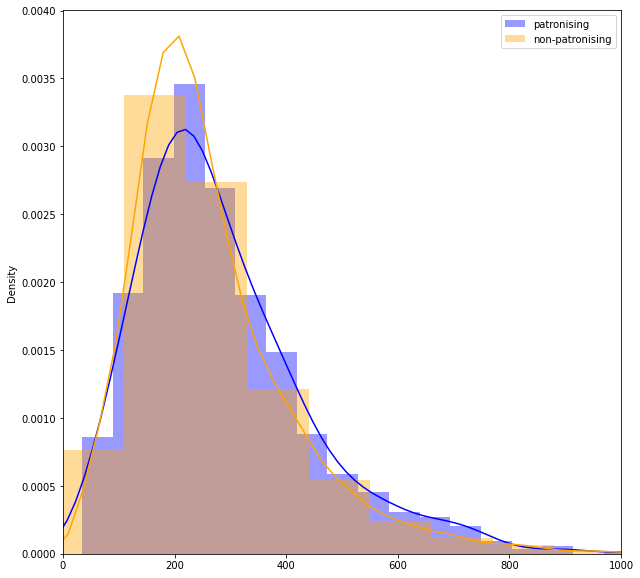

In [36]:
fig = plt.figure(figsize=(10,10))

lengths_pos = np.array([len(txt) for txt in orig_train["text"][orig_train["label"] == 1]])
lengths_neg = np.array([len(txt) for txt in orig_train["text"][orig_train["label"] == 0]])

sns.distplot(lengths_pos, color = "blue", label = "patronising")
sns.distplot(lengths_neg, color = "orange", label = "non-patronising")

print(f"Mean positive text length = {np.mean(lengths_pos)}")
print(f"Mean negative text length = {np.mean(lengths_neg)}")

plt.legend()
plt.xlim((0,1000))
plt.show()



# Rebuild training set (Task 1)

In [37]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

In [38]:
trdf1 = pd.DataFrame(rows)

In [39]:
trdf1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
8370,8380,Rescue teams search for survivors on the rubbl...,0
8371,8381,The launch of ' Happy Birthday ' took place la...,0
8372,8382,"The unrest has left at least 20,000 people dea...",0
8373,8383,You have to see it from my perspective . I may...,0


# Rebuild test set (Task 1)

In [40]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  orig_label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]

  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'country': country,
      'keyword':keyword,
      'orig_label':orig_label
  })

In [41]:
tedf1 = pd.DataFrame(rows)

In [42]:
tedf1

,par_id,text,label,country,keyword,orig_label
0,4046,We also know that they can benefit by receivin...,1,us,hopeless,3
1,1279,Pope Francis washed and kissed the feet of Mus...,1,ng,refugee,4
2,8330,Many refugees do n't want to be resettled anyw...,1,ng,refugee,2
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...",1,ie,in-need,4
4,4089,"""In a 90-degree view of his constituency , one...",1,pk,homeless,3
...,...,...,...,...,...,...
2089,10462,"The sad spectacle , which occurred on Saturday...",0,gh,homeless,0
2090,10463,""""""" The Pakistani police came to our house and...",0,pk,refugee,0
2091,10464,"""When Marie O'Donoghue went looking for a spec...",0,ie,disabled,0
2092,10465,"""Sri Lankan norms and culture inhibit women fr...",0,lk,women,1


# RoBERTa Baseline for Task 1

In [43]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [44]:
## ------------------TRAIN BASELINE-------------------------
task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)

# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2382 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [45]:
Counter(preds_task1)

Counter({0: 1587, 1: 507})

In [46]:
#BASELINE
f1_score(tedf1.label, preds_task1)

0.4560906515580737

## **Data Augmentation**

In [47]:
from nlpaug.augmenter.word.context_word_embs import ContextualWordEmbsAug


aug = ContextualWordEmbsAug(
    model_path='roberta-base', action="insert")
augmented_text = aug.augment(text)

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [48]:
WORDEMBEDD = True

if WORDEMBEDD:
  trdf1 = trdf1.sample(frac=1).reset_index(drop=True)

  augmented_list = []
  for i, sentence in enumerate(trdf1['text'][trdf1['label'] == 1][:100]):
    augmented_list.append(aug.augment(sentence))


  for i, sentence in enumerate(trdf1['text'][trdf1['label'] == 1][100:200]):
    augmented_list.append(aug.augment(sentence))

  labels = [1] * 200
  par_id = list(trdf1['par_id'][trdf1['label'] == 1][:200])

  augmented_texts_new = pd.DataFrame(list(zip(par_id, augmented_list, labels)), columns = ['par_id', 'text', 'label'])

  trdf1 = trdf1.append(augmented_texts_new, ignore_index=True)
  
  trdf1 = trdf1.sample(frac=1).reset_index(drop=True)

In [49]:
class PatronisingDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        input_copy = input_set.copy().reset_index()

        self.tokenizer = tokenizer
        self.texts = input_copy['text']
        self.labels = input_copy['label']
        
    def collate_fn(self, batch):

        texts = []
        dat_labels = []

        for b in batch:
            texts.append(b['text'])
            dat_labels.append(b['labels'])


        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=64)
        labels = {}
        encodings["labels"] = torch.tensor(dat_labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        
        item = {'text': self.texts[idx],
                'labels': self.labels[idx]
        }

        return item

In [50]:
class PatronisingDatasetTest(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        input_copy = input_set.copy().reset_index()

        self.tokenizer = tokenizer
        self.texts = input_copy['text']

        if 'label' in input_copy.columns:
          self.labels = input_copy['label']

        if 'keyword' in input_copy.columns:
          self.keyword = input_copy['keyword']

        if 'country' in input_copy.columns:
          self.country = input_copy['country']

        if 'orig_label' in input_copy.columns:
          self.orig_label = input_copy['orig_label']
        
    def collate_fn(self, batch):

        texts = []
        dat_labels = []

        for b in batch:
            texts.append(b['text'])
            dat_labels.append(b['labels'])

        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=64)
        labels = {}
        encodings["labels"] = torch.tensor(dat_labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        
        item = {'text': self.texts[idx],
                'labels': self.labels[idx],
                'keyword': self.keyword[idx],
                'country': self.country[idx],
                'orig_label': self.orig_label[idx]
        }

        return item

In [51]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

#split train into train and val
train_set, val_set = train_test_split(trdf1, test_size=0.2)

patr_training_set1 = PatronisingDataset(tokenizer, train_set)
patr_val_set1 = PatronisingDatasetTest(tokenizer, val_set)
patr_test_set1 = PatronisingDatasetTest(tokenizer, tedf1)

print(len(train_set), len(val_set), len(tedf1))

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

6860 1715 2094


In [52]:
patr_training_set1.texts

0       "US President Donald Trump allegedly said that...
1       This comes after Maendeleo Ya Wanawake Organis...
2       Handwalla Bwana is a forward . He currently pl...
3       Secondary sub-menu <h> About 40 evacuated from...
4       Witnesses said immigrants angry at delays in g...
                              ...                        
6855    Some people have sued after finding a mirror o...
6856    This is one of the doors , which the foreign i...
6857    Tier 3 is for the worst offenders of forced la...
6858    "Cardinal Tagle , who has visited refugee sett...
6859    Whenever the term'disabled'humanity is mention...
Name: text, Length: 6860, dtype: object

In [53]:
#retrieve batches
batch = []
for i in range(len(patr_training_set1)):
  batch.append(patr_training_set1[i])

In [54]:
#batch = [sample for sample in patr_training_set1]

encodings = patr_training_set1.collate_fn(batch[:10])

for key, value in encodings.items():

  print(f"{key}: {value.numpy().tolist()}")

input_ids: [[1, 113, 3048, 270, 807, 140, 2346, 26, 14, 32935, 4175, 7, 5, 315, 532, 41039, 70, 33, 17296, 41039, 8, 92, 5572, 2071, 11, 5, 247, 197, 41039, 213, 124, 7, 49, 1368, 7046, 2156, 41039, 309, 7, 10, 382, 340, 266, 1027, 378, 39058, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 713, 606, 71, 3066, 1397, 6902, 139, 23059, 18015, 1584, 5113, 13158, 8381, 5970, 10890, 873, 6186, 9060, 21, 1654, 7, 7014, 2864, 11, 5, 558, 688, 536, 71, 10, 333, 9, 5800, 390, 3751, 7, 29277, 69, 8601, 69, 9, 3834, 14668, 8, 23422, 479, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 21292, 12764, 102, 163, 19102, 16, 10, 556, 479, 91, 855, 1974, 13, 3417, 36802, 5429, 9, 5454, 815, 10433, 11, 730, 479, 91, 21, 2421, 11, 256, 5223, 8810, 11, 6193, 2156, 53, 1240, 411, 107, 9, 39, 6585, 23, 10, 7220, 2205, 11, 26452, 5037, 480, 10720, 128, 11671, 6751, 128, 7, 29348, 39, 2959, 479, 2], [1, 32703, 1766, 2849, 12, 45801, 28696, 298, 15698, 1936, 843, 9593, 31, 7220, 1312, 11, 6171, 71, 8769, 2, 0, 0, 0,

In [55]:
#reweighing classes
class_weights = torch.tensor([0.5, 5]).to('cuda' if cuda_available else 'cpu')

In [56]:
class PatronisingTrainer(Trainer):
    def compute_loss(self, model, inputs):
        labels = inputs.pop('labels')
        outputs = model(**inputs, labels=labels)

        logits = outputs.get('logits')

        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_func(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return loss

## **Hyperparameter Tuning** 

The following cells use `wandb`to tune the hyperparameters of our models and shouldn't be run by the TA's when running the notebook. 

In [57]:
#log in to a wandb session
#!wandb login

In [58]:
#set up wandb sweep configuration for hyperparam tuning
#sweep_config = {
#    "method": "bayes",  # grid, random
#    "metric": {"name": "train_loss", "goal": "minimize"},
#    "parameters": {#"learning_rate": {"values": [1e-6, 5e-6, 1.5e-5, 5e-5, 1e-4]},
                   #"per_device_train_batch_size": {"values": [8, 16, 32, 64, 128]}#
#                   'warmup_steps': {"values": [100]}
#                  },
#}

#configure sweep
#sweep_id = wandb.sweep(sweep_config, project="NLP Warmup Sweep 2")

#set logging info
#logging.basicConfig(level=logging.INFO)
#transformers_logger = logging.getLogger("transformers")
#transformers_logger.setLevel(logging.WARNING)

In [59]:
def predict(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  #print(encodings)
  output = model(**encodings)
  logits = output.get('logits')
  preds = torch.max(logits, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

def evaluate(model, tokenizer, data_loader):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []
  
  keywords = []
  countries = []
  text_length = []
  orig_label = []
  with torch.no_grad():
    for i, data in enumerate(data_loader): 
    #   print(data)
    #   print(labels[i])
      text = data['text']

      output = predict(text, tokenizer, model)
      preds.append(output['prediction'].tolist())
      tot_labels.append(data['labels'].tolist())
      
      keywords.append(data['keyword'])
      countries.append(data['country'])
      orig_label.append(data['orig_label'][0])

      # print(preds[i])
  # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  report = classification_report(tot_labels, preds, target_names=["Not offensive","Offensive"], output_dict= True)
  
  final_df = pd.DataFrame(list(zip(preds, tot_labels, keywords, countries, orig_label)), columns = ['prediction', 'actual', 'keyword', 'country', 'orig_label'])
  
  return report, final_df

In [60]:
def hyperparam_sweep():
    with wandb.init() as run:
        #random seed for reproducibility
        #np.random.seed(0)
        #torch.manual_seed(0)

        #call our custom BERT model and pass as parameter the name of an available pretrained model
        model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")

        #set fixed hyperparameters in wandb configuration
        wandb.config.output_dir = './experiment/patronising_speech'
        wandb.config.learning_rate = 5e-6
        wandb.config.per_device_train_batch_size = 16
        #wandb.config.warmup_steps = 1000
        wandb.config.logging_steps = 50
        wandb.config.num_train_epochs = 3
        wandb.config.adam_beta1 = 0.9
        wandb.config.adam_beta2 = 0.999
        wandb.config.adam_epsilon = 1e-6

        config = wandb.config #get sweep hyperparameter configuration
        
        #set up training args
        training_args = TrainingArguments(**config)

        #set up trainer
        trainer = PatronisingTrainer(
            model=model,                         
            args=training_args,                 
            train_dataset = patr_training_set1,                   
            data_collator = patr_training_set1.collate_fn
        )

        #train model
        trainer.train()

        #save model in drive
        model_name = './models/ht_bob_finetuned/' 
        trainer.save_model(model_name)

        #evaluate on val set and log run on wnadb
        model = DebertaForSequenceClassification.from_pretrained(model_name)
        report, final_df = evaluate(model, tokenizer, val_loader)
        f1 = report['Offensive']['f1-score']

        wandb.log({"f1 score": f1})

        # Sync wandb
        wandb.join()

In [61]:
#tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base') #your saved model name here
#val_loader = DataLoader(patr_val_set1)

#count = 3 # number of runs to execute
#wandb.agent(sweep_id, function=hyperparam_sweep, count=count)

In [70]:
def train(lr = 5e-6, logging_steps = 50, per_device_train_batch_size = 16, num_train_epochs = 7, 
          warmup_steps = 50, adam_beta1 = 0.9, adam_beta2 = 0.999, adam_epsilon =1e-6):

    #call our custom BERT model and pass as parameter the name of an available pretrained model
    model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")

    #set up training args
    training_args = TrainingArguments(
        output_dir='./experiment/patronising_speech',
        learning_rate = lr,
        logging_steps = logging_steps, 
        per_device_train_batch_size = per_device_train_batch_size,
        num_train_epochs = num_train_epochs,
        warmup_steps = warmup_steps, 
        adam_beta1 = adam_beta1, 
        adam_beta2 = adam_beta2, 
        adam_epsilon = adam_epsilon
    )

    #set up trainer
    trainer = PatronisingTrainer(
        model=model,                         
        args=training_args,                 
        train_dataset = patr_training_set1,                   
        data_collator = patr_training_set1.collate_fn
    )

    trainer.train() #train model

    #save model in drive
    model_name = './models/ht_bob_finetuned/' 
    trainer.save_model(model_name)

In [71]:
#train model
import os 
os.environ["WANDB_DISABLED"] = "true"

train()

loading configuration file https://huggingface.co/microsoft/deberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e313266bff73867debdfa78c78a9a4966d5e78281ac4ed7048c178b16a37eba7.fb501413b9cef9cef6babdc543bb4153cbec58d52bce077647efba3e3f14ccf3
Model config DebertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "transformers_version": "4.17.0",
  "type_vocab_size": 0,
  "vocab_size": 50265
}

Some weights of the model checkpoint at mic

Step,Training Loss
50,0.691200
100,0.683900
150,0.677600
200,0.612400
250,0.563300
300,0.581100
350,0.474200
400,0.555700
450,0.397700
500,0.432200


Saving model checkpoint to ./experiment/patronising_speech/checkpoint-500
Configuration saved in ./experiment/patronising_speech/checkpoint-500/config.json
Saving model checkpoint to ./experiment/patronising_speech/checkpoint-1000
Configuration saved in ./experiment/patronising_speech/checkpoint-1000/config.json
Saving model checkpoint to ./experiment/patronising_speech/checkpoint-1500
Configuration saved in ./experiment/patronising_speech/checkpoint-1500/config.json
Saving model checkpoint to ./experiment/patronising_speech/checkpoint-2000
Configuration saved in ./experiment/patronising_speech/checkpoint-2000/config.json
Saving model checkpoint to ./experiment/patronising_speech/checkpoint-2500
Configuration saved in ./experiment/patronising_speech/checkpoint-2500/config.json
Saving model checkpoint to ./experiment/patronising_speech/checkpoint-3000
Configuration saved in ./experiment/patronising_speech/checkpoint-3000/config.json


Training completed. Do not forget to share your mode

## Evaluate on Official Dev Set

In [72]:
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base') #your saved model name here
model_name = './models/ht_bob_finetuned/' 
model = DebertaForSequenceClassification.from_pretrained(model_name)
test_loader = DataLoader(patr_test_set1)
report, final_df = evaluate(model, tokenizer, test_loader)

print(report)
print(report['accuracy'])
print(report['Not offensive']['f1-score'])
print(report['Offensive']['f1-score'])

loading configuration file https://huggingface.co/microsoft/deberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e313266bff73867debdfa78c78a9a4966d5e78281ac4ed7048c178b16a37eba7.fb501413b9cef9cef6babdc543bb4153cbec58d52bce077647efba3e3f14ccf3
Model config DebertaConfig {
  "_name_or_path": "microsoft/deberta-base",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "transformers_version": "4.17.0",
  "type_vocab_size": 0,
  "vocab_size": 50265
}

{'Not offensive': {'precision': 0.9538057742782152, 'recall': 0.9588390501319262, 'f1-score': 0.9563157894736842, 'support': 1895}, 'Offensive': {'precision': 0.5873015873015873, 'recall': 0.5577889447236181, 'f1-score': 0.5721649484536082, 'support': 199}, 'accuracy': 0.9207258834765998, 'macro avg': {'precision': 0.7705536807899013, 'recall': 0.7583139974277722, 'f1-score': 0.7642403689636462, 'support': 2094}, 'weighted avg': {'precision': 0.9189756247040275, 'recall': 0.9207258834765998, 'f1-score': 0.9198086178581183, 'support': 2094}}
0.9207258834765998
0.9563157894736842
0.5721649484536082


## Analysis 

### 1). **To what extent is the model better at predicting examples with a higher level of patronising content?**

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


f1 score for: 2 is 0.19999999999999998
f1 score for: 3 is 0.7007299270072993
f1 score for: 4 is 0.7973856209150326


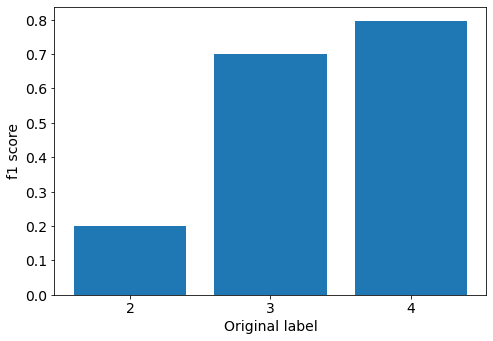

In [73]:
unique_orig_labels = ['2','3','4']

f1_values = []
for cc in unique_orig_labels:
  actual_labels = list(final_df['actual'][final_df['orig_label'] == cc])
  predictions = list(final_df['prediction'][final_df['orig_label'] == cc])
  f1 = f1_score(actual_labels, predictions)
  f1_values.append(f1)
  print(f"f1 score for: {cc} is {f1}")


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_orig_labels,f1_values)
ax.set_ylabel("f1 score", fontsize=14)
ax.set_xlabel("Original label", fontsize=14)
ax.tick_params(axis='both', labelsize=14)
plt.show()

### 3). **How does the length of the input sequence impact the model performance? If there is any difference, speculate why.**

f1 score for: lk is 0.6666666666666666
f1 score for: ke is 0.6428571428571429
f1 score for: ng is 0.5714285714285715
f1 score for: ca is 0.6666666666666666
f1 score for: ph is 0.5517241379310344
f1 score for: au is 0.2857142857142857
f1 score for: us is 0.4347826086956522
f1 score for: jm is 0.5714285714285713
f1 score for: sg is 0.5
f1 score for: pk is 0.5217391304347826
f1 score for: in is 0.5
f1 score for: za is 0.6666666666666666
f1 score for: tz is 0.5555555555555556
f1 score for: nz is 0.631578947368421
f1 score for: bd is 0.39999999999999997
f1 score for: gb is 0.3333333333333333
f1 score for: gh is 0.6363636363636365
f1 score for: hk is 0.8
f1 score for: my is 0.631578947368421
f1 score for: ie is 0.7777777777777777


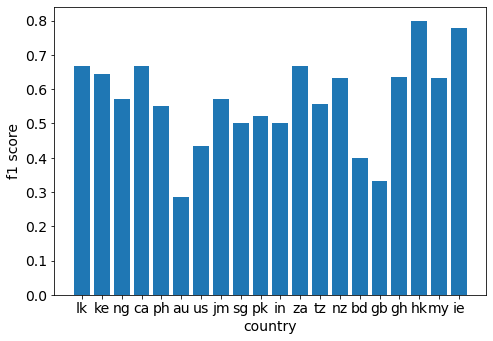

In [74]:
final_df['country'] = [country[0] for country in list(final_df['country'])]
final_df['keyword '] = [country[0] for country in list(final_df['keyword'])]
final_df['prediction'] = [country[0] for country in list(final_df['prediction'])]
final_df['actual'] = [country[0] for country in list(final_df['actual'])]

unique_countries = list(set(list(final_df['country'])))

f1_values = []
for cc in unique_countries:
  actual_labels = list(final_df['actual'][final_df['country'] == cc])
  predictions = list(final_df['prediction'][final_df['country'] == cc])
  f1 = f1_score(actual_labels, predictions)
  f1_values.append(f1)
  print(f"f1 score for: {cc} is {f1}")


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_countries,f1_values)
ax.set_ylabel("f1 score", fontsize=14)
ax.set_xlabel("country", fontsize=14)
ax.tick_params(axis='both', labelsize=14)
plt.show()

f1 score for: hopeless is 0.4444444444444444
f1 score for: migrant is 0.5714285714285715
f1 score for: women is 0.5
f1 score for: in-need is 0.7733333333333333
f1 score for: vulnerable is 0.6511627906976744
f1 score for: refugee is 0.46153846153846156
f1 score for: homeless is 0.5538461538461539
f1 score for: immigrant is 0.25
f1 score for: poor-families is 0.5142857142857142
f1 score for: disabled is 0.56


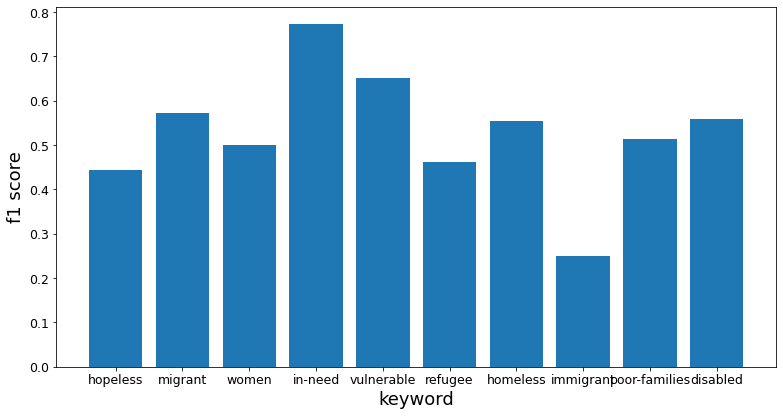

In [75]:
unique_countries = list(set(list(final_df['keyword '])))

f1_values = []
for cc in unique_countries:
  actual_labels = list(final_df['actual'][final_df['keyword '] == cc])
  predictions = list(final_df['prediction'][final_df['keyword '] == cc])
  f1 = f1_score(actual_labels, predictions)
  f1_values.append(f1)
  print(f"f1 score for: {cc} is {f1}")


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_countries,f1_values)
ax.set_ylabel("f1 score", fontsize=18)
ax.set_xlabel("keyword", fontsize=18)
ax.tick_params(axis='both', labelsize=12.5)
plt.show()

### 2). **To what extent does the categorical data provided influence the model predictions?**

In [ ]:
test_loader = DataLoader(patr_test_set1)

preds = []
tot_labels = []
tot_labels1 = []
text_length = []
with torch.no_grad():
    for i, data in enumerate(test_loader): 
        texts = data['text']
        text_length.append(len(data['text'][0]))
        pred = predict(texts, tokenizer, model)
        preds.append(pred['prediction'].tolist())
        tot_labels.append(data['labels'].tolist())
        tot_labels1.append(data['labels'].tolist()[0])
x = np.array(text_length)
preds = np.array(preds)
tot_labels = np.array(tot_labels)
bins = np.linspace(0, max(text_length), 10)
inds = np.digitize(x, bins)
f1 = []
bins_count = []
unique, counts = np.unique(inds, return_counts=True)
for i in unique:
    curr_labels = tot_labels[inds==i].transpose()[0]
    curr_preds = preds[inds==i].transpose()[0]
    f1.append(f1_score(curr_labels, curr_preds))

In [ ]:
# plot
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(bins[1:8], f1[:-1], color="red", marker="o")
ax.set_xlabel("Text length",fontsize=17)
ax.set_ylabel("f1-score",color="red",fontsize=17)
ax2=ax.twinx()
ax2.plot(bins[1:8], counts[:-1],color="blue",marker="o")
ax2.set_ylabel("Length frequency",color="blue",fontsize=17)
plt.show()

## **Predict on Held Out Test Set**

Need to redefine PatronisingDatasetTest since held out test set doesnt have the same columns as the dev sets

In [ ]:
class PatronisingDatasetFINALTest(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        input_copy = input_set.copy().reset_index()

        self.tokenizer = tokenizer
        self.texts = input_copy['text']

        if 'label' in input_copy.columns:
          self.labels = input_copy['label']

        if 'keyword' in input_copy.columns:
          self.keyword = input_copy['keyword']

        if 'country' in input_copy.columns:
          self.country = input_copy['country']

        if 'orig_label' in input_copy.columns:
          self.orig_label = input_copy['orig_label']
        
    def collate_fn(self, batch):

        texts = []
        dat_labels = []

        for b in batch:
            texts.append(b['text'])
            dat_labels.append(b['labels'])

        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=64)
        labels = {}
        encodings["labels"] = torch.tensor(dat_labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        
        item = {'text': self.texts[idx]}

        return item

In [ ]:
%cd '/NLP_CW'

In [ ]:
test_set = pd.read_csv("task4_test.tsv", sep='\t', header=None) #read file
test_set.columns = ['0', '1', 'keyword', 'country', 'text']
test_set

In [ ]:
%cd '../'

In [ ]:
#convert to PatronisingDatasetTestObject
patr_final_test_set = PatronisingDatasetFINALTest(tokenizer, test_set) 
model_name = './models/ht_bob_finetuned/' 
model = DebertaForSequenceClassification.from_pretrained(model_name)
test_loader = DataLoader(patr_final_test_set)

preds = []
with torch.no_grad():
  for i, data in enumerate(test_loader): 
  #   print(data)
  #   print(labels[i])
    text = data['text']

    output = predict(text, tokenizer, model)
    preds.append(output['prediction'].tolist())

In [ ]:
np.savetxt('task1.txt', preds)
len(preds)